In [17]:
import tensorflow as tf
from tensorflow import keras

import numpy as np 

print(tf.__version__)   # Tensorflow의 버전을 출력

mnist = keras.datasets.mnist

# MNIST 데이터를 로드. 다운로드하지 않았다면 다운로드까지 자동으로 진행됩니다. 
(x_train, y_train), (x_test, y_test) = mnist.load_data()   

2.8.2


In [18]:
x_train = x_train.reshape(-1,784)
print(x_train.shape)

(60000, 784)


In [19]:
y_train.shape

(60000,)

In [20]:
total_epochs = 100
batch_size = 100
learning_rate = 0.0002

In [21]:
def generator( z , reuse = False ) :
    if reuse==False :
        with tf.variable_scope(name_or_scope = "Gen") as scope :
            gw1 = tf.get_variable(name = "w1",
                                  shape = [128, 256],
                                  initializer= tf.random_normal_initializer(mean=0.0, stddev = 0.01))
            # quiz : weight 의 초깃값을 random normal 로 주는 이유는 무엇일까요?

            gb1 = tf.get_variable(name = "b1",
                                 shape = [256],
                                 initializer = tf.random_normal_initializer(mean=0.0, stddev = 0.01))

            gw2 = tf.get_variable(name = "w2",
                                  shape = [256, 784],
                                  initializer= tf.random_normal_initializer(mean=0.0, stddev = 0.01))

            gb2 = tf.get_variable(name = "b2",
                                 shape = [784],
                                 initializer = tf.random_normal_initializer(mean=0.0, stddev = 0.01))
    else :
        with tf.variable_scope(name_or_scope="Gen", reuse = True) as scope :
            gw1 = tf.get_variable(name = "w1",
                                  shape = [128, 256],
                                  initializer= tf.random_normal_initializer(mean=0.0, stddev = 0.01))

            gb1 = tf.get_variable(name = "b1",
                                 shape = [256],
                                 initializer = tf.random_normal_initializer(mean=0.0, stddev = 0.01))

            gw2 = tf.get_variable(name = "w2",
                                  shape = [256, 784],
                                  initializer= tf.random_normal_initializer(mean=0.0, stddev = 0.01))

            gb2 = tf.get_variable(name = "b2",
                                 shape = [784],
                                 initializer = tf.random_normal_initializer(mean=0.0, stddev = 0.01))


    hidden = tf.nn.relu( tf.matmul(z , gw1) + gb1 )
    output = tf.nn.sigmoid( tf.matmul(hidden, gw2) + gb2 )   #출력층에 시그모이드를 쓰는 이유는 무엇일까요?

    return output   #[784] 가짜 생성된 이미지


In [22]:
def discriminator( x , reuse = False) :

    if(reuse == False) :
        with tf.variable_scope(name_or_scope="Dis") as scope :
            dw1 = tf.get_variable(name = "w1",
                                  shape = [784, 256],
                                  initializer = tf.random_normal_initializer(0.0, 0.01) )
            db1 = tf.get_variable(name = "b1",
                                  shape = [256],
                                  initializer = tf.random_normal_initializer(0.0, 0.01) )
            dw2 = tf.get_variable(name = "w2",
                                  shape = [256, 1],
                                  initializer = tf.random_normal_initializer(0.0, 0.01) )
            db2 = tf.get_variable(name = "b2",
                                  shape = [1],
                                  initializer = tf.random_normal_initializer(0.0, 0.01) )
    else :
        with tf.variable_scope(name_or_scope="Dis", reuse = True) as scope :
            dw1 = tf.get_variable(name = "w1",
                                  shape = [784, 256],
                                  initializer = tf.random_normal_initializer(0.0, 0.01) )
            db1 = tf.get_variable(name = "b1",
                                  shape = [256],
                                  initializer = tf.random_normal_initializer(0.0, 0.01) )
            dw2 = tf.get_variable(name = "w2",
                                  shape = [256, 1],
                                  initializer = tf.random_normal_initializer(0.0, 0.01) )
            db2 = tf.get_variable(name = "b2",
                                  shape = [1],
                                  initializer = tf.random_normal_initializer(0.0, 0.01) )

    hidden = tf.nn.relu( tf.matmul(x , dw1) + db1 )  #[-, 256]
    output = tf.nn.sigmoid( tf.matmul(hidden, dw2)  + db2 )   #[-, 1]  진품인지(1) 가품인지(0)의 label 결과값

    return output

In [23]:
def random_noise(batch_size) :
    return np.random.normal(size=[batch_size , 128])

In [25]:
import tensorflow.compat.v1 as tf

g = tf.Graph()

with g.as_default() :

    ######################################################
    # 1 .Feedable part  :: 그래프에서 유일하게 데이터가 유입될 수 있는 장소
    ######################################################

    X = tf.placeholder(tf.float32, [None, 784]) #GAN 은 autoencoder 와 마찬가지로 unsupervised learning 이므로 y(label)을 사용하지 않습니다.

    Z = tf.placeholder(tf.float32, [None, 128]) #Z 는 생성기의 입력값으로 사용될 노이즈 입니다.


    ################################
    # 2. generator 와 discriminator 의 사용
    ##################################


    fake_x = generator(Z)

    result_of_fake = discriminator(fake_x)
    result_of_real = discriminator(X , True)


    ################################
    # 3. Loss( 성취도평가 ) : g_loss 와 d_loss

    # g_loss & d_loss 모두 높을 수록 좋다.
    # g_loss : 얼마나 fake_x 가 진짜같은가
    # d_loss : 얼마나 discriminator 가 정확한가

    # 두 수치를 모두 높이도록 train 하면 생성기와 분류기의 성능이 모두 올라간다.
    ################################

    g_loss = tf.reduce_mean( tf.log(result_of_fake) )
    d_loss = tf.reduce_mean( tf.log(result_of_real) + tf.log(1 - result_of_fake) )


    ################################
    # 4. Train : Maximizing g_loss & d_loss
    ################################

    t_vars = tf.trainable_variables() # return list

    g_vars = [var for var in t_vars if "Gen" in var.name]
    d_vars = [var for var in t_vars if "Dis" in var.name]

    optimizer = tf.train.AdamOptimizer(learning_rate)

    g_train = optimizer.minimize(-g_loss, var_list= g_vars)
    d_train = optimizer.minimize(-d_loss, var_list = d_vars)    

    # g_loss & d_loss 를 최대화 시켜야하는데 minimize 함수밖에 없기 때문에 - 음수부호 붙인다.




=======Epoch :  1  =======================================
생성기 성능 :  -2.1775367
분류기 성능 :  -0.12033636
생성기와 분류기 선의의 경쟁중...
=======Epoch :  19  =======================================
생성기 성능 :  nan
분류기 성능 :  nan
생성기와 분류기 선의의 경쟁중...
=======Epoch :  39  =======================================
생성기 성능 :  nan
분류기 성능 :  nan
생성기와 분류기 선의의 경쟁중...
=======Epoch :  59  =======================================
생성기 성능 :  nan
분류기 성능 :  nan
생성기와 분류기 선의의 경쟁중...
=======Epoch :  79  =======================================
생성기 성능 :  nan
분류기 성능 :  nan
생성기와 분류기 선의의 경쟁중...
=======Epoch :  99  =======================================
생성기 성능 :  nan
분류기 성능 :  nan
생성기와 분류기 선의의 경쟁중...
최적화 완료!


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


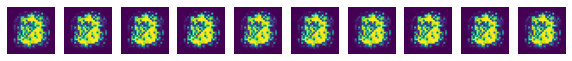

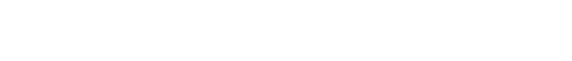

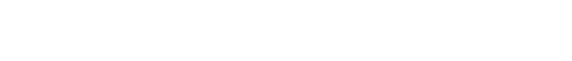

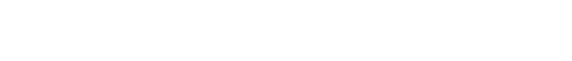

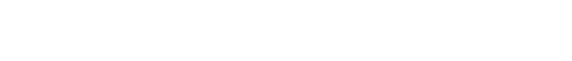

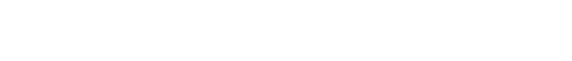

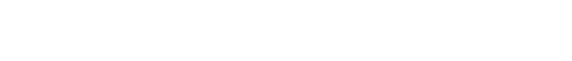

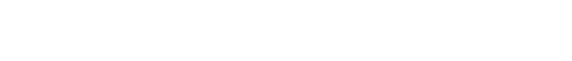

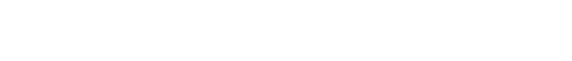

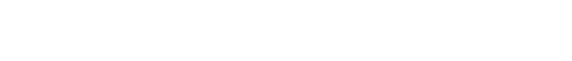

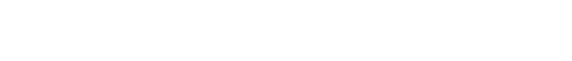

In [27]:
import matplotlib.pyplot as plt

with tf.Session(graph = g) as sess :
    sess.run(tf.global_variables_initializer())

    total_batchs = int(x_train.shape[0] / batch_size)

    for epoch in range(total_epochs) :

        for batch in range(total_batchs) :
            batch_x = x_train[batch * batch_size : (batch+1) * batch_size]  # [batch_size , 784]
            batch_y = x_train[batch * batch_size : (batch+1) * batch_size]  # [batch_size,]
            noise = random_noise(batch_size)  # [batch_size, 128]

            sess.run(g_train , feed_dict = {Z : noise})
            sess.run(d_train, feed_dict = {X : batch_x , Z : noise})

            gl, dl = sess.run([g_loss, d_loss], feed_dict = {X : batch_x , Z : noise})


        #매 20 epoch 마다 학습된 성능을 중간점검  (실제론 더 자주하시는 것이 좋습니다. )
        if (epoch+1) % 20 == 0 or epoch == 1  :
            print("=======Epoch : ", epoch , " =======================================")
            print("생성기 성능 : " ,gl )
            print("분류기 성능 : " ,dl )
            print("생성기와 분류기 선의의 경쟁중...")


        #10개의 epoch 마다 Generator 가 만들어내는 실제 결과물을 얻어보며 , 성능 발전을 시각적으로 확인

        if epoch == 0 or (epoch + 1) % 10 == 0  :
            sample_noise = random_noise(10)

            generated = sess.run(fake_x , feed_dict = { Z : sample_noise})

            fig, ax = plt.subplots(1, 10, figsize=(10, 1))
            for i in range(10) :
                ax[i].set_axis_off()
                ax[i].imshow( np.reshape( generated[i], (28, 28)) )


    print('최적화 완료!')
